<a href="https://colab.research.google.com/github/dsklnr/ADS_509_Module6/blob/main/Sentiment_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 3.9 MB/s eta 0:00:00


In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
# Add any additional import statements you need here
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Create a google drive connection
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define paths
data_location = '/content/drive/My Drive/ADS 509/M1 Results/'
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"
positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

# Define paths for the lyrics and twitter folders
# and positive, negative, and tidy text files
lyrics_path = os.path.join(data_location, lyrics_folder)
twitter_path = os.path.join(data_location, twitter_folder)
pos_words_path = os.path.join(data_location, positive_words_file)
neg_words_path = os.path.join(data_location, negative_words_file)
tidy_text_path = os.path.join(data_location, tidy_text_file)
os.listdir(data_location)

['twitter',
 'lyrics',
 'negative-words.txt',
 'positive-words.txt',
 'tidytext_sentiments.txt']

In [5]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/rsadeghian/textmining/ads-tm-api-scrape/"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.




In [6]:
# Read in the lyrics data
# Function to load all lyric files for an artist
def load_lyrics(artist_folder):
    lyrics_data = []

    artist_path = os.path.join(lyrics_path, artist_folder)

    # Iterate through all the files in the artist's lyrics folder
    for filename in os.listdir(artist_path):
        if filename.endswith(".txt"):  # Assuming lyrics files are .txt
            with open(os.path.join(artist_path, filename), 'r', encoding='utf-8') as file:
                lyrics = file.read()
                # Assuming the song title is the filename (without extension)
                song = os.path.splitext(filename)[0]
                lyrics_data.append({"song": song, "lyrics": lyrics})

    # Convert to DataFrame
    return pd.DataFrame(lyrics_data)

In [7]:
# Function to convert all '_data.txt' files to .csv
def convert_txt_to_csv():
    files = os.listdir(twitter_path)

    # Iterate through all files and pick those ending with '_data.txt'
    for filename in files:
        if filename.endswith("_data.txt"):
            file_path = os.path.join(twitter_path, filename)

            try:
                # Read the txt file into a DataFrame (assuming tab-separated)
                df = pd.read_csv(file_path, delimiter="\t", on_bad_lines='skip')

                # Define the new CSV file path
                csv_filename = filename.replace("_data.txt", ".csv")
                csv_file_path = os.path.join(twitter_path, csv_filename)

                # Save the DataFrame as a CSV file
                df.to_csv(csv_file_path, index=False)
                print(f"Converted {filename} to {csv_filename}")

            except pd.errors.ParserError as e:
                print(f"Error parsing {filename}: {e}")

convert_txt_to_csv()

Converted cher_followers_data.txt to cher_followers.csv
Converted robynkonichiwa_followers_data.txt to robynkonichiwa_followers.csv


In [8]:
# Read in the twitter data
# Function to load Twitter data (only _data.txt files) for an artist
def load_twitter(artist_name):
    twitter_df = pd.DataFrame()

    # Iterate through all files in the twitter folder
    for filename in os.listdir(twitter_path):
        if filename.startswith(artist_name) and filename.endswith(".csv"):
            print(filename)
            file_path = os.path.join(twitter_path, filename)

            # Read the CSV file and select only the 'description' column
            df = pd.read_csv(file_path, usecols=['description'])

            # Append the data to the artist's twitter DataFrame
            twitter_df = pd.concat([twitter_df, df], ignore_index=True)
    return twitter_df

load_twitter(twitter_folder)

""


In [ ]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a
# dictionary for this.

In [9]:
# Function to read words from a file while ignoring comments
def read_words(file_path):
    with open(file_path, 'r') as f:
        # Read lines and filter out comments
        words = [line.strip() for line in f if line.strip() and not line.startswith(';')]
    return words

# Read in positive words and negative words, ignoring comments
positive_words = read_words(pos_words_path)
negative_words = read_words(neg_words_path)

# Create a DataFrame
sentiment_words = pd.DataFrame({
    'word': positive_words + negative_words,
    'score': [1] * len(positive_words) + [-1] * len(negative_words)
})

In [10]:
sentiment_words.head()

,word,score
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [11]:
# List of artist folders
artist_folders = ["cher", "robyn"]

# Dictionary to hold dataframes for each artist
artist_lyrics_dfs = {}
artist_twitter_dfs = {}

# Loop through each artist and store their lyrics in DataFrames
for artist in artist_folders:
    artist_lyrics_df = load_lyrics(artist)
    artist_lyrics_dfs[artist] = artist_lyrics_df

    # Load twitter data for the artist
    artist_twitter_df = load_twitter(artist)
    artist_twitter_dfs[artist] = artist_twitter_df

cher_followers.csv
robynkonichiwa_followers.csv


In [12]:
artist_lyrics_dfs['cher'].head()

,song,lyrics
0,cher_thetwelfthofnever,"""The Twelfth Of Never""\n\n\n\nYou ask how much..."
1,cher_olmanriver,"""Ol' Man River""\n\n\n\nHere we all work 'long ..."
2,cher_ayounggirluneenfante,"""A Young Girl (Une Enfante)""\n\n\n\nShe left h..."
3,cher_dontthinktwice,"""Don't Think Twice""\n\n\n\nIt ain't no use to ..."
4,cher_comeandstaywithme,"""Come And Stay With Me""\n\n\n\nI'll send away ..."


In [13]:
# Drop null values from the 'description' column for the artist 'Cher'
artist_twitter_dfs['cher'] = artist_twitter_dfs['cher'].dropna(subset=['description'])
artist_twitter_dfs['cher'].head()

,description
1,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,csu
4,Writer @Washinformer @SpelmanCollege alumna #D...
6,I’m unemployed and live with my parents. MOOPS!


In [14]:
artist_lyrics_dfs['robyn'].head()

,song,lyrics
0,robyn_shouldhaveknown,"""Should Have Known""\n\n\n\nI should have seen ..."
1,robyn_sayit,"""Sayit""\n\n\n\nSay it\n\nSay say say...\n\nSay..."
2,robyn_underneaththeheart,"""Underneath The Heart""\n\n\n\nI look into your..."
3,robyn_longgone,"""Long Gone""\n\n\n\nLong gone\n\nLips move, I c..."
4,robyn_loveisfree,"""Love Is Free""\n\n\n\nFree\nLove is free, baby..."


In [15]:
# Drop null values from the 'description' column for the artist 'Cher'
artist_twitter_dfs['robyn'] = artist_twitter_dfs['robyn'].dropna(subset=['description'])
artist_twitter_dfs['robyn'].head()

,description
0,I love chill •Facebook / Instagram / SoundClou...
1,"books, movies, music, nature & TV shows. OG Sw..."
2,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...
3,This Twitter profile is full of sarcasm and ra...
4,Flora Youssef - Blogger & Founder Posting revi...


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [16]:
# Function to calculate sentiment score for lyrics
def calculate_sentiment(lyrics, lexicon):
    # Initialize sentiment score
    score = 0

    # Tokenize lyrics (you might want to adjust this depending on your tokenization method)
    tokens = lyrics.split()  # Simple split by whitespace

    # Calculate score based on the lexicon
    for token in tokens:
        token = token.lower()  # Convert to lowercase for matching
        if token in lexicon['word'].values:
            score += lexicon.loc[lexicon['word'] == token, 'score'].values[0]

    return score

# Load combined lexicon
# Assuming 'sentiment_words' is the DataFrame from earlier with words and scores
lexicon = sentiment_words

In [17]:
# Dictionary to hold sentiment scores for each artist's songs
artist_sentiments = {artist: [] for artist in artist_folders}

# Loop through each artist's lyrics DataFrame
for artist in artist_folders:
    # Get the lyrics DataFrame for the artist
    lyrics_df = artist_lyrics_dfs[artist]

    # Calculate sentiment scores for each song
    for index, row in lyrics_df.iterrows():
        lyric_text = row['lyrics']  # Assuming the lyrics are in a column named 'lyric'
        sentiment_score = calculate_sentiment(lyric_text, lexicon)
        artist_sentiments[artist].append(sentiment_score)

    # Add the sentiment scores to the DataFrame
    lyrics_df['sentiment_score'] = artist_sentiments[artist]

In [18]:
print("Sentiment scores for cher:")
artist_lyrics_dfs["cher"].head()

Sentiment scores for cher:


,song,lyrics,sentiment_score
0,cher_thetwelfthofnever,"""The Twelfth Of Never""\n\n\n\nYou ask how much...",8
1,cher_olmanriver,"""Ol' Man River""\n\n\n\nHere we all work 'long ...",-5
2,cher_ayounggirluneenfante,"""A Young Girl (Une Enfante)""\n\n\n\nShe left h...",3
3,cher_dontthinktwice,"""Don't Think Twice""\n\n\n\nIt ain't no use to ...",7
4,cher_comeandstaywithme,"""Come And Stay With Me""\n\n\n\nI'll send away ...",3


In [19]:
print("Sentiment scores for robyn:")
artist_lyrics_dfs["robyn"].head()

Sentiment scores for robyn:


,song,lyrics,sentiment_score
0,robyn_shouldhaveknown,"""Should Have Known""\n\n\n\nI should have seen ...",1
1,robyn_sayit,"""Sayit""\n\n\n\nSay it\n\nSay say say...\n\nSay...",2
2,robyn_underneaththeheart,"""Underneath The Heart""\n\n\n\nI look into your...",3
3,robyn_longgone,"""Long Gone""\n\n\n\nLong gone\n\nLips move, I c...",-2
4,robyn_loveisfree,"""Love Is Free""\n\n\n\nFree\nLove is free, baby...",91


In [20]:
# Calculate the average sentiment score for Cher
cher_avg_sentiment = artist_lyrics_dfs["cher"]['sentiment_score'].mean()
print(f"Mean sentiment score per song for Cher: {cher_avg_sentiment}")

# Calculate the average sentiment score for Robyn
robyn_avg_sentiment = artist_lyrics_dfs["robyn"]['sentiment_score'].mean()
print(f"Mean sentiment score per song for Robyn: {robyn_avg_sentiment}")

Average sentiment score per song for Cher: 3.161392405063291
Average sentiment score per song for Robyn: 2.019230769230769


In [24]:
# Sort the lyrics DataFrame for Cher by sentiment score
cher_sorted = artist_lyrics_dfs["cher"].sort_values(by='sentiment_score', ascending=False)

# Get the top 3 songs with the highest sentiment scores
cher_top_3 = cher_sorted.head(3)

# Get the bottom 3 songs with the lowest sentiment scores
cher_bottom_3 = cher_sorted.tail(3)

# Print the top 3 highest sentiment songs and their lyrics
print("Top 3 songs with the highest sentiment scores for Cher:")
for index, row in cher_top_3.iterrows():
    print(f"Song: {row['song']}")
    print(f"Sentiment Score: {row['sentiment_score']}")

# Print the bottom 3 lowest sentiment songs and their lyrics
print("Top 3 songs with the lowest sentiment scores for Cher:")
for index, row in cher_bottom_3.iterrows():
    print(f"Song: {row['song']}")
    print(f"Sentiment Score: {row['sentiment_score']}")

Top 3 songs with the highest sentiment scores for Cher:
Song: cher_perfection
Sentiment Score: 41
Song: cher_loveandunderstanding
Sentiment Score: 41
Song: cher_mylove
Sentiment Score: 34
Top 3 songs with the lowest sentiment scores for Cher:
Song: cher_dressedtokill
Sentiment Score: -16
Song: cher_outrageous
Sentiment Score: -20
Song: cher_iwalkonguildedsplinters
Sentiment Score: -24


In [26]:
# Sort the lyrics DataFrame for Robyn by sentiment score
robyn_sorted = artist_lyrics_dfs["robyn"].sort_values(by='sentiment_score', ascending=False)

# Get the top 3 songs with the highest sentiment scores
robyn_top_3 = robyn_sorted.head(3)

# Get the bottom 3 songs with the lowest sentiment scores
robyn_bottom_3 = robyn_sorted.tail(4)

# Print the top 3 highest sentiment songs and their lyrics
print("Top 3 songs with the highest sentiment scores for Robyn:")
for index, row in robyn_top_3.iterrows():
    print(f"Song: {row['song']}")
    print(f"Sentiment Score: {row['sentiment_score']}")

# Print the bottom 3 lowest sentiment songs and their lyrics
print("Top 3 songs with the lowest sentiment scores for Robyn:")
for index, row in robyn_bottom_3.iterrows():
    print(f"Song: {row['song']}")
    print(f"Sentiment Score: {row['sentiment_score']}")

Top 3 songs with the highest sentiment scores for Robyn:
Song: robyn_loveisfree
Sentiment Score: 91
Song: robyn_indestructible
Sentiment Score: 26
Song: robyn_ushouldknowbetter
Sentiment Score: 25
Top 3 songs with the lowest sentiment scores for Robyn:
Song: robyn_crashandburngirl
Sentiment Score: -23
Song: robyn_criminalintent
Sentiment Score: -54
Song: robyn_dontfuckingtellmewhattodo114520
Sentiment Score: -77
Song: robyn_dontfuckingtellmewhattodo
Sentiment Score: -77


### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: <!-- Your answer here -->
Overall, Cher has a higher sentiment score. Based on the songs each artist has made, Cher has a higher sentiment score by 1.14 points.
---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: My first artist is Cher. Her top three songs that have the highest sentiment scores include perfection (41 points), love and understanding (41 points), and my love (34 points). Her top three songs that have the lowest sentiment scores include I walk on guilded splinters (-24 points), outrageous (-20 points), and dressed to kill (-16 points). Driving these sentiment scores is obviously positive and negative words, but deeper than that we can conclude the highest sentiment scores stem from love songs, becoming a better person, and joy that Cher has experienced in her life. On the flip side, the lowest sentiment scores come from songs that are about painful experiences, issues Cher has delt with in the past, and dressing well (this is funny becaue it uses negative words)


---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: Robyn is my second artist. Her top three songs that have the highest sentiment scores include love is free (91 points), indestructible (26 points), and u should know better (25 points). Her top three songs that have the lowest sentiment scores include dont fucking tell me what to do (-77 points), criminal intent (-54 points), and crash and burn girl (-23 points). Driving these sentiment scores is obviously positive and negative words, but deeper than that we can conclude the highest sentiment scores stem from love songs, a high sense of self-worth, and euphoria from overcoming adversity Robyn has experienced in her life. On the flip side, the lowest sentiment scores come from songs that are about painful experiences, possible issues with the law, and wanting more independence.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




<ipython-input-30-53a6b940dbb2>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(artist_lyrics_dfs["cher"]['sentiment_score'], label="Cher", shade=True)
<ipython-input-30-53a6b940dbb2>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(artist_lyrics_dfs["robyn"]['sentiment_score'], label="Robyn", shade=True)


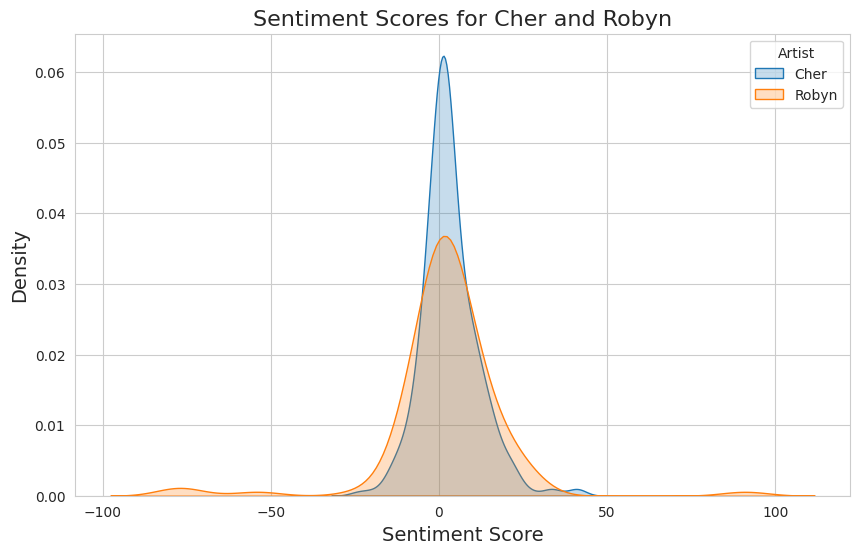

In [30]:
# Set up the figure size and style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot the sentiment score distributions for both artists
sns.kdeplot(artist_lyrics_dfs["cher"]['sentiment_score'], label="Cher", shade=True)
sns.kdeplot(artist_lyrics_dfs["robyn"]['sentiment_score'], label="Robyn", shade=True)

# Add titles and labels
plt.title("Sentiment Scores for Cher and Robyn", fontsize=16)
plt.xlabel("Sentiment Score", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Show the legend
plt.legend(title="Artist")

# Show the plot
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [35]:
# Define updated positive and negative emoji sets with 20 emojis each
positive_emojis = {'😊', '😍', '😂', '🤣', '❤️', '👍', '😎', '🎉', '🌟', '💕', '😁', '😄', '😆', '😇', '🙌', '🙏', '💪', '👏', '💖', '✨'}
negative_emojis = {'😢', '😡', '💔', '😠', '😞', '😩', '👎', '😭', '😤', '🤬', '😣', '😖', '😫', '😓', '😥', '😔', '😕', '😢', '😒', '😰'}

# Assign sentiment scores
emoji_sentiment = {emoji: 1 for emoji in positive_emojis}
emoji_sentiment.update({emoji: -1 for emoji in negative_emojis})

In [36]:
# Function to extract emojis and calculate sentiment score for a given description
def calculate_emoji_sentiment(description):
    score = 0
    for char in description:
        if char in emoji_sentiment:
            score += emoji_sentiment[char]
    return score

# Calculate sentiment scores for each artist's followers based on their Twitter descriptions
artist_twitter_sentiments = {}

for artist in artist_folders:
    # Get the Twitter DataFrame for the artist
    twitter_df = artist_twitter_dfs[artist]

    # Initialize total sentiment score and number of followers
    total_score = 0
    follower_count = len(twitter_df)

    # Calculate sentiment score for each follower's description
    for index, row in twitter_df.iterrows():
        description = row['description']
        sentiment_score = calculate_emoji_sentiment(description)
        total_score += sentiment_score

    # Calculate the average sentiment score (total score / number of followers)
    average_sentiment = total_score / follower_count if follower_count > 0 else 0
    artist_twitter_sentiments[artist] = average_sentiment

In [37]:
# Print the average sentiment score for each artist
for artist, avg_sentiment in artist_twitter_sentiments.items():
    print(f"Average emoji-based sentiment score for {artist}: {avg_sentiment}")

Average emoji-based sentiment score for cher: 0.0489752825546065
Average emoji-based sentiment score for robyn: 0.026908803114405192


In [38]:
# Function to count emoji occurrences in descriptions
def count_emojis(twitter_df):
    emoji_counter = Counter()

    for description in twitter_df['description']:
        for char in description:
            if char in emoji_sentiment:  # Only consider emojis in our sentiment dictionary
                emoji_counter[char] += 1
    return emoji_counter

# Initialize dictionaries to store the most popular positive and negative emojis for each artist
artist_most_popular_positive = {}
artist_most_popular_negative = {}

# Analyze each artist's Twitter data
for artist in artist_folders:
    # Get the Twitter DataFrame for the artist
    twitter_df = artist_twitter_dfs[artist]

    # Count the emojis in the descriptions
    emoji_counts = count_emojis(twitter_df)

    # Separate the positive and negative emojis
    positive_emoji_counts = {emoji: count for emoji, count in emoji_counts.items() if emoji in positive_emojis}
    negative_emoji_counts = {emoji: count for emoji, count in emoji_counts.items() if emoji in negative_emojis}

    # Get the most popular positive and negative emoji
    most_popular_positive = max(positive_emoji_counts, key=positive_emoji_counts.get, default=None)
    most_popular_negative = max(negative_emoji_counts, key=negative_emoji_counts.get, default=None)

    # Store the results for each artist
    artist_most_popular_positive[artist] = most_popular_positive
    artist_most_popular_negative[artist] = most_popular_negative

# Print the most popular positive and negative emojis for each artist
for artist in artist_folders:
    print(f"Most popular positive emoji for {artist}: {artist_most_popular_positive[artist]}")
    print(f"Most popular negative emoji for {artist}: {artist_most_popular_negative[artist]}")

Most popular positive emoji for cher: ✨
Most popular negative emoji for cher: 💔
Most popular positive emoji for robyn: ✨
Most popular negative emoji for robyn: 💔


Q: What is the average sentiment of your two artists?

A: The mean sentiment of cher was 0.049 points and of robyn was 0.027 points.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A: The star (✨) is the most popular positive emoji for both cher and robyn. Additionally, the broken heart (💔) is the most popular negative emoji for both cher and robyn

